In [2]:
from collections import Counter
from typing import List, Dict
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.patheffects import withStroke

# Read csvs

In [3]:
def get_csv_dict(names: List[str], csv_root: str) -> Dict[str, pd.DataFrame]:
    csv_dict = {}

    for name in names:
        csv_dict[name] = {}
        csv_dict[name]["train"] = pd.read_csv(os.path.join(csv_root, f"{name}_train_1M.csv"))
        csv_dict[name]["valid"] = pd.read_csv(os.path.join(csv_root, f"{name}_valid_500k.csv"))
    
    return csv_dict

In [4]:
names = ["fhv", "green", "yellow"]

csv_dict = get_csv_dict(names, "../dataset_nyc_taxi_samples/csv")

/tmp/ipykernel_8946/2931299872.py:6: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_dict[name]["train"] = pd.read_csv(os.path.join(csv_root, f"{name}_train_1M.csv"))
/tmp/ipykernel_8946/2931299872.py:7: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_dict[name]["valid"] = pd.read_csv(os.path.join(csv_root, f"{name}_valid_500k.csv"))


# Shapefile mappings

In [5]:
shapefile = gpd.read_file("../taxi_zones")
location_to_borough_mapping = dict(zip(shapefile['LocationID'], shapefile['borough']))
borough_to_borough_idx_mappng = {'Manhattan': 0, 'Queens': 1, 'Brooklyn': 2, 'Bronx': 3, 'EWR': 4, 'Staten Island': 5}

location_to_borough_idx_mapping = dict(zip(shapefile['LocationID'], shapefile['borough'].map(borough_to_borough_idx_mappng)))
shapefile['borough_id'] = shapefile['borough'].map(borough_to_borough_idx_mappng)


In [39]:
for name in names:
    # change id, map borough to id
    csv_dict[name]["train"]["PUBoroughID"] = (csv_dict[name]["train"]["PULocationID"]-1).map(location_to_borough_idx_mapping)
    csv_dict[name]["train"]["DOBoroughID"] = (csv_dict[name]["train"]["DOLocationID"]-1).map(location_to_borough_idx_mapping)
    csv_dict[name]["valid"]["PUBoroughID"] = (csv_dict[name]["valid"]["PULocationID"]-1).map(location_to_borough_idx_mapping)
    csv_dict[name]["valid"]["DOBoroughID"] = (csv_dict[name]["valid"]["DOLocationID"]-1).map(location_to_borough_idx_mapping)

    # drop nans on PUBoroughID, DOBoroughID
    len_train_before = len(csv_dict[name]["train"])
    len_valid_before = len(csv_dict[name]["valid"])

    csv_dict[name]["train"].dropna(subset=["PUBoroughID", "DOBoroughID"], inplace=True)
    csv_dict[name]["valid"].dropna(subset=["PUBoroughID", "DOBoroughID"], inplace=True)

    len_train_after = len(csv_dict[name]["train"])
    len_valid_after = len(csv_dict[name]["valid"])
    
    print(f"{name} - train reduced: {(len_train_before-len_train_after)/len_train_before}%, num samples: {len_train_before-len_train_after}")
    print(f"{name} - valid reduced: {(len_valid_before-len_valid_after)/len_valid_before}%, num samples: {len_valid_before-len_valid_after}")



fhv - train reduced: 0.04622652547534069%, num samples: 46225
fhv - valid reduced: 0.046376608701738944%, num samples: 23189
green - train reduced: 0.009171275138254147%, num samples: 9171
green - valid reduced: 0.009237630494780208%, num samples: 4619
yellow - train reduced: 0.005849181324621063%, num samples: 5849
yellow - valid reduced: 0.0057577927194620996%, num samples: 2879


In [40]:
# get centroids used for adding text to plots
def get_zones_centroids(shapefile: pd.DataFrame):
    combined_zones = []

    for cluster_id in shapefile['borough'].unique():
        cluster_zones = shapefile[shapefile['borough'] == cluster_id]
        combined_geometry = cluster_zones.unary_union
        combined_zones.append(combined_geometry)

    combined_zones_geoseries = gpd.GeoSeries(combined_zones)
    combined_zones_gdf = gpd.GeoDataFrame(geometry=combined_zones_geoseries)
    combined_zones_gdf['ZONE_ID'] = shapefile['borough'].unique()

    zones = {
        "x_coords": combined_zones_gdf.geometry.centroid.x, 
        "y_coords": combined_zones_gdf.geometry.centroid.y, 
        "zones_labels": combined_zones_gdf['ZONE_ID'],
    }

    return zones

zones_dict = get_zones_centroids(shapefile)

# Plots

In [124]:
def feature_subplots(taxi_dict_values: Dict, csv_dict: Dict, zones_dict: Dict, samples_treshold: int, mode, unit: str):
    dol_pul_values = ["PUBoroughID", "DOBoroughID"]

    num_rows = len(taxi_dict_values)
    _, axes = plt.subplots(num_rows, 2, figsize=(15,7*num_rows))

    for idx_dp, dol_pul in enumerate(dol_pul_values):
        for idx_taxi, (taxi_type, feature) in enumerate(taxi_dict_values.items()):
            
            # concat train with valid, count samples
            df = pd.concat([csv_dict[taxi_type]["train"], csv_dict[taxi_type]["valid"]])
            df_borough_counts = Counter(df[dol_pul])

            # perform computations on dataframe:
            if mode=="mean":
                # - compute means, merge with shapefile
                df_means = df.groupby(by=dol_pul)[feature].mean().reset_index()
                df_merged = pd.merge(shapefile, df_means[[dol_pul, feature]], left_on='borough_id', right_on=dol_pul, how='outer')
            elif mode=="percent":
                # - compute percent of samples where specified param is greater than 0 and not none/nzn
                total_count = df.groupby(by=dol_pul)[feature].count()
                valid_count = df[df[feature] > 0].groupby(by=dol_pul)[feature].count()
                percentage = (valid_count / total_count) * 100
                df_percentage = pd.DataFrame({dol_pul: percentage.index, feature: percentage.values})
                df_merged = pd.merge(shapefile, df_percentage[[dol_pul, feature]], left_on='borough_id', right_on=dol_pul, how='outer')

            # drop during plot zones where number of samples is less than treshold
            selected_zones = [key for key, value in df_borough_counts.items() if value < samples_treshold]
            df_merged[~df_merged[dol_pul].isin(selected_zones)].plot(ax=axes[idx_taxi, idx_dp], column=feature, legend=True)

            axes[idx_taxi, idx_dp].axis('off')
            axes[idx_taxi, idx_dp].set_title(f"{taxi_type}: {feature} / {dol_pul}")

            # add text based on precomputed centroids
            df_all_counts = len(df)
            for x_coord, y_coord, zones_label in zip(zones_dict["x_coords"], zones_dict["y_coords"], zones_dict["zones_labels"]):
                zone_value = round(df_merged[df_merged[dol_pul] == borough_to_borough_idx_mappng[zones_label]][feature].iloc[0], 2)
                borough_count = df_borough_counts[borough_to_borough_idx_mappng[zones_label]]
                text = f"{zones_label} - {zone_value}{unit} \n{round(100*borough_count/df_all_counts, 2)}% - {borough_count}"
                
                axes[idx_taxi, idx_dp].text(x_coord, y_coord, text, fontsize=9, ha='center', path_effects=[withStroke(linewidth=3, foreground='white')])

# Tips

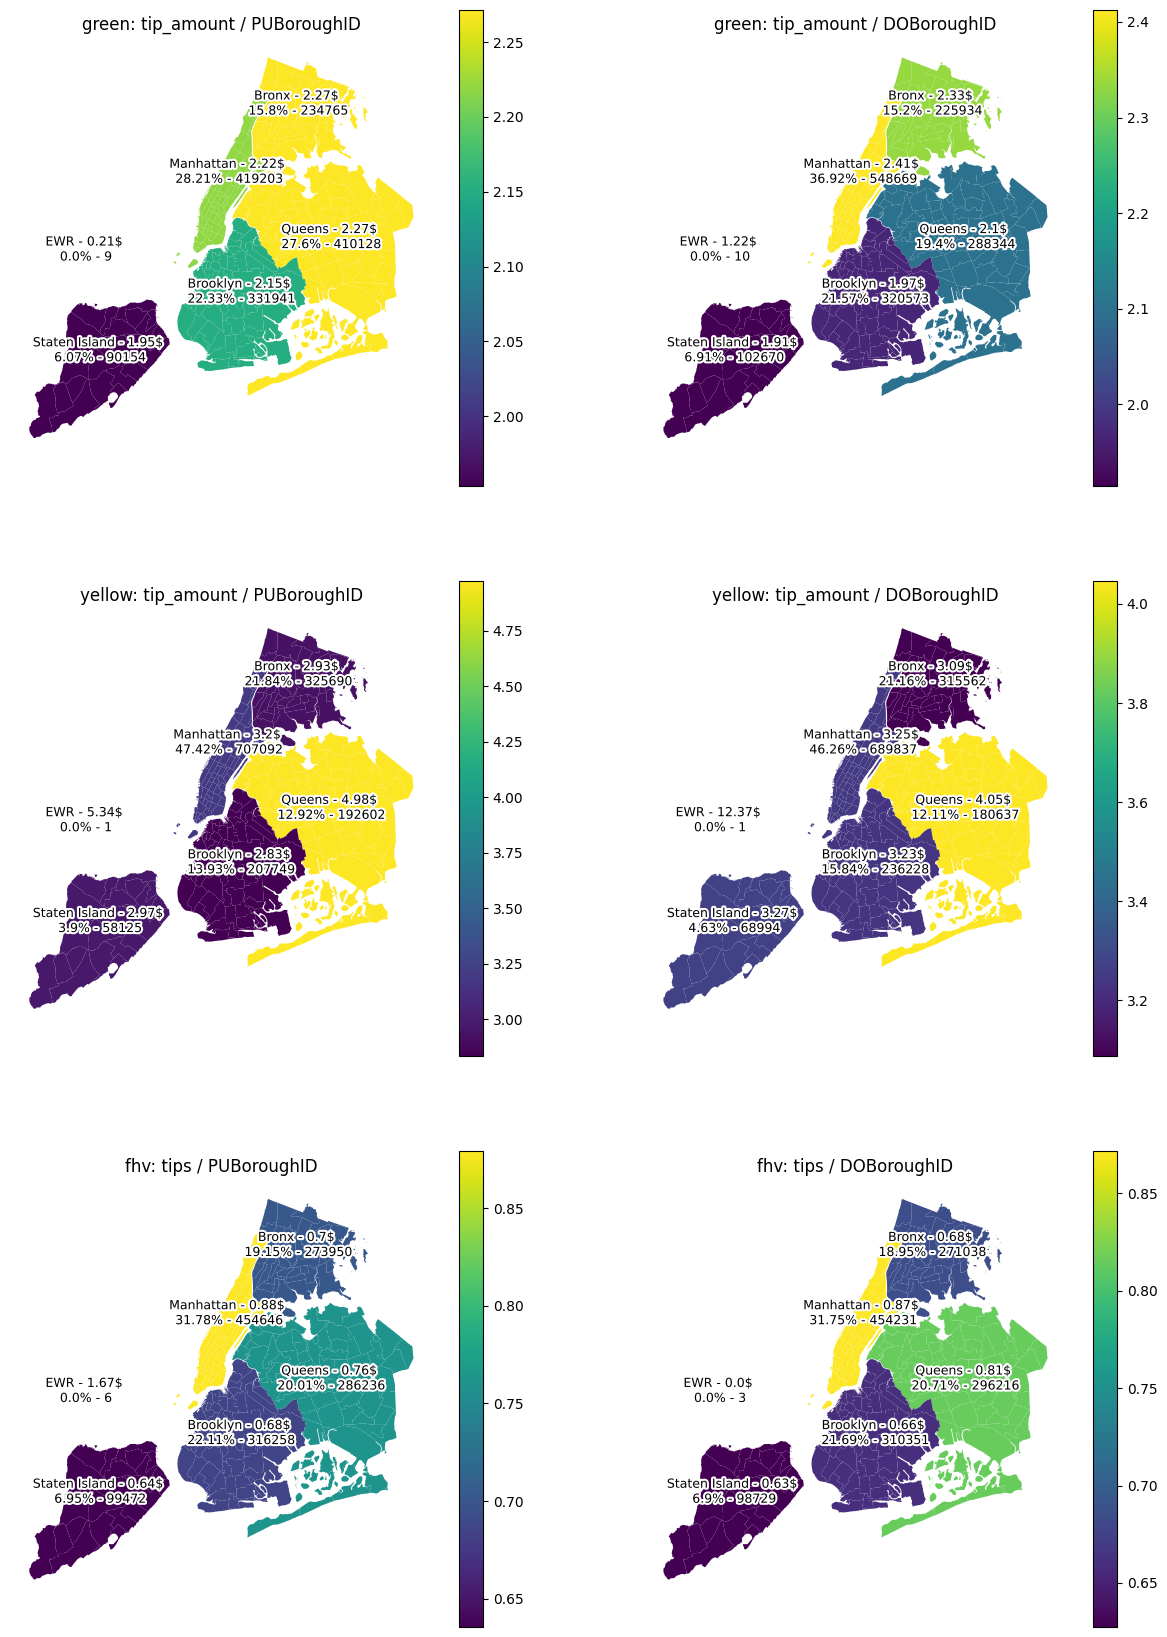

In [111]:
taxi_dict_values = {
    "green": "tip_amount", 
    "yellow": "tip_amount", 
    "fhv": "tips"
}

feature_subplots(
    taxi_dict_values=taxi_dict_values,
    csv_dict=csv_dict,
    zones_dict=zones_dict,
    samples_treshold=20,
    unit="$"
)

# Tips - greater than zero and not none/nan

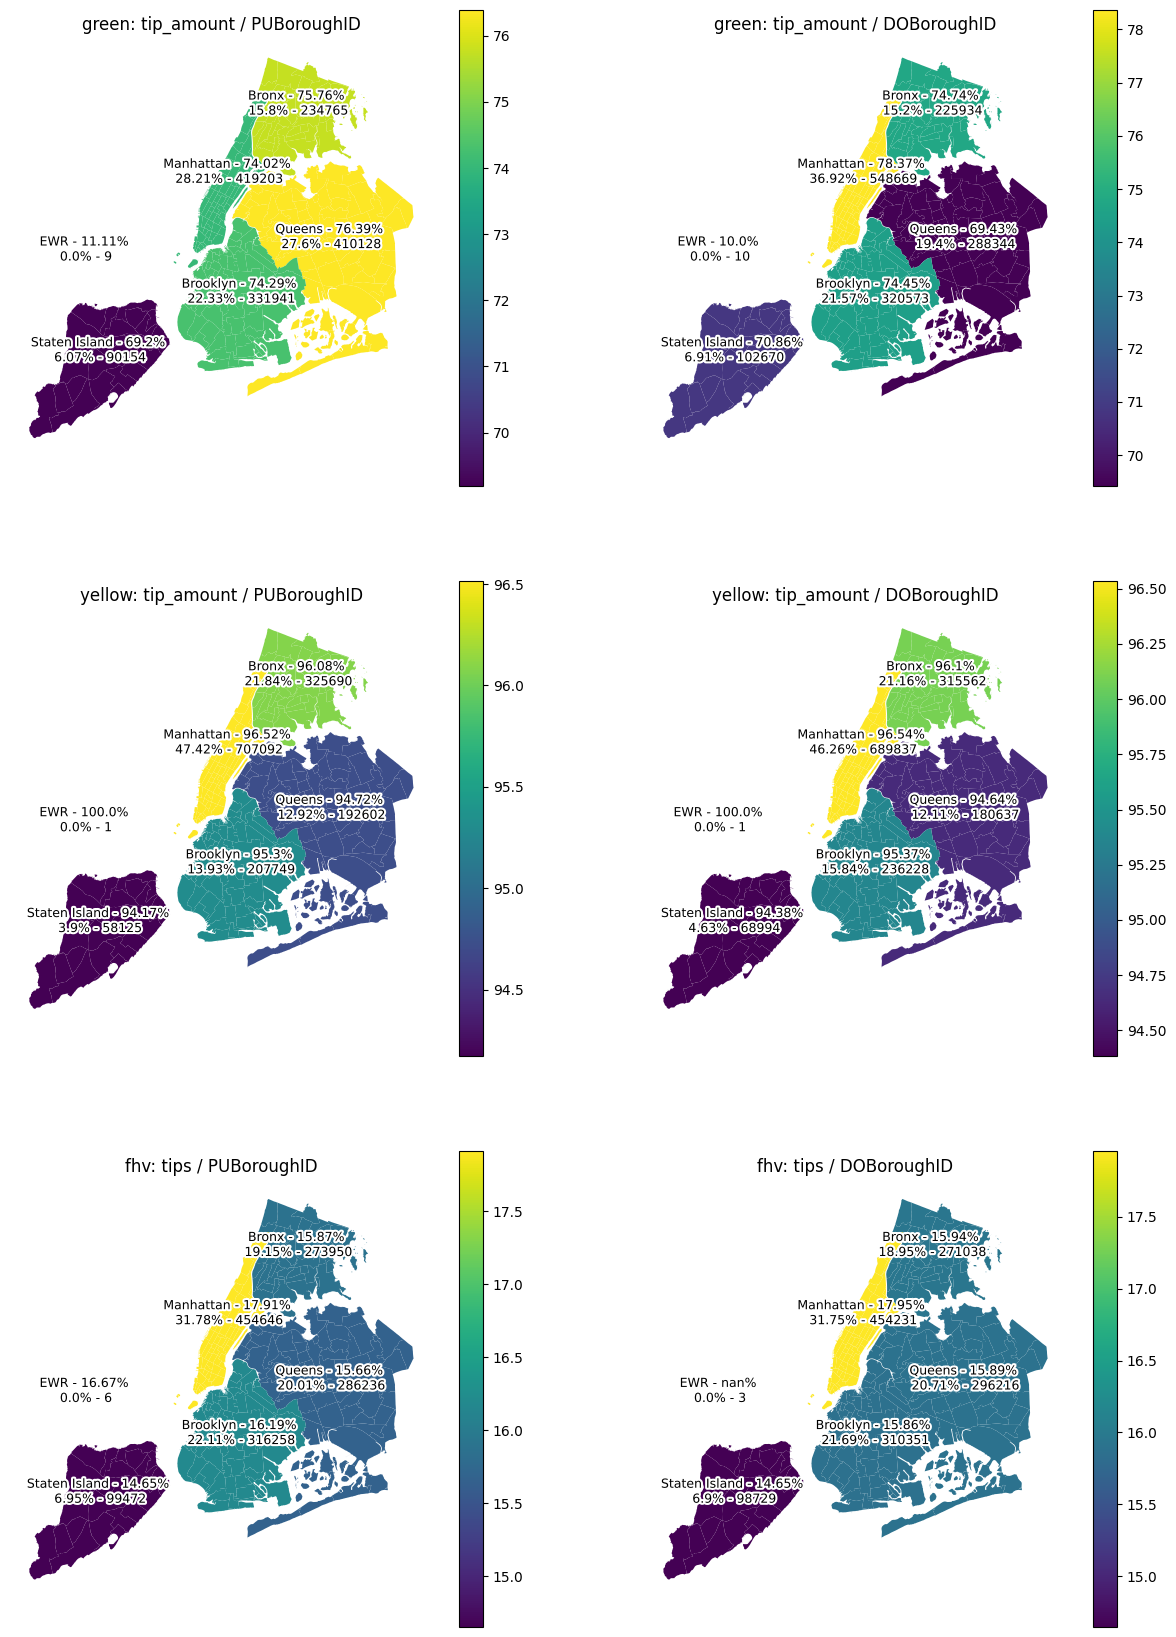

In [126]:
taxi_dict_values = {
    "green": "tip_amount", 
    "yellow": "tip_amount", 
    "fhv": "tips"
}

feature_subplots(
    taxi_dict_values=taxi_dict_values,
    csv_dict=csv_dict,
    zones_dict=zones_dict,
    samples_treshold=20,
    mode="percent",
    unit="%"
)

# Distance

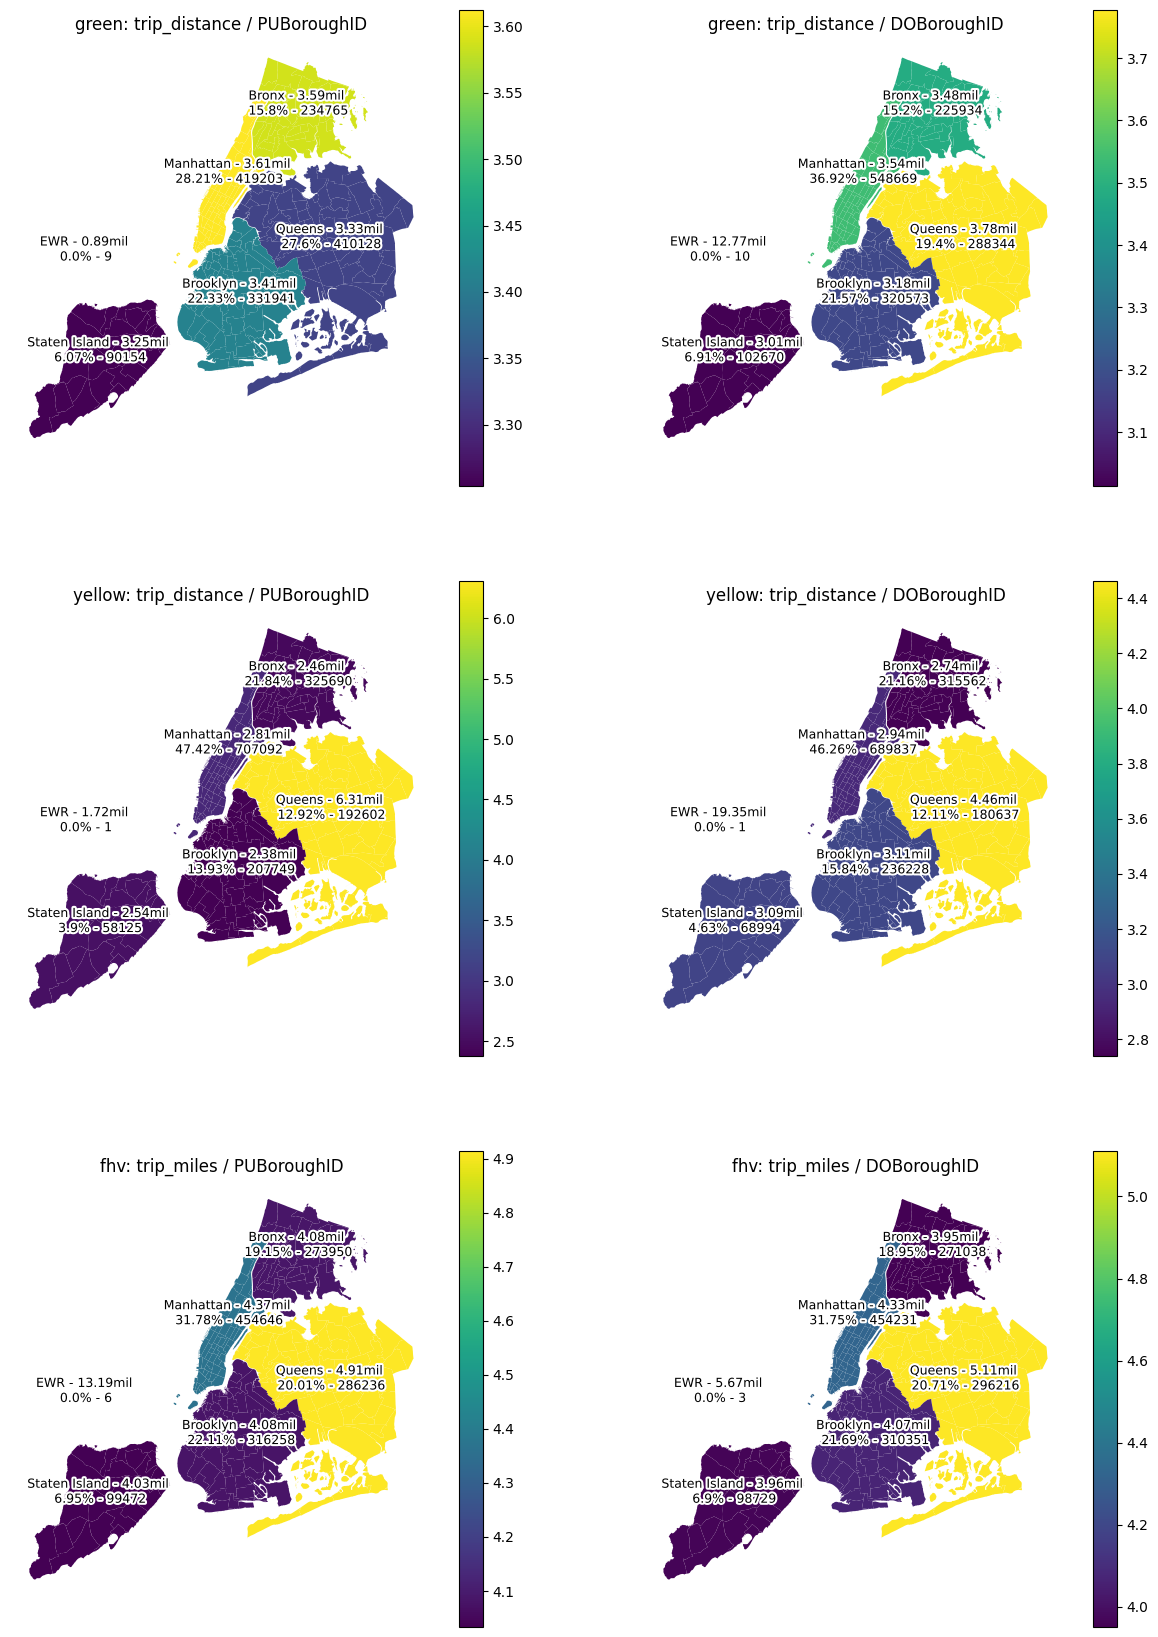

In [112]:
taxi_dict_values = {
    "green": "trip_distance", 
    "yellow": "trip_distance", 
    "fhv": "trip_miles"
}

feature_subplots(
    taxi_dict_values=taxi_dict_values,
    csv_dict=csv_dict,
    zones_dict=zones_dict,
    samples_treshold=20,
    unit="mil"
)

# Fare

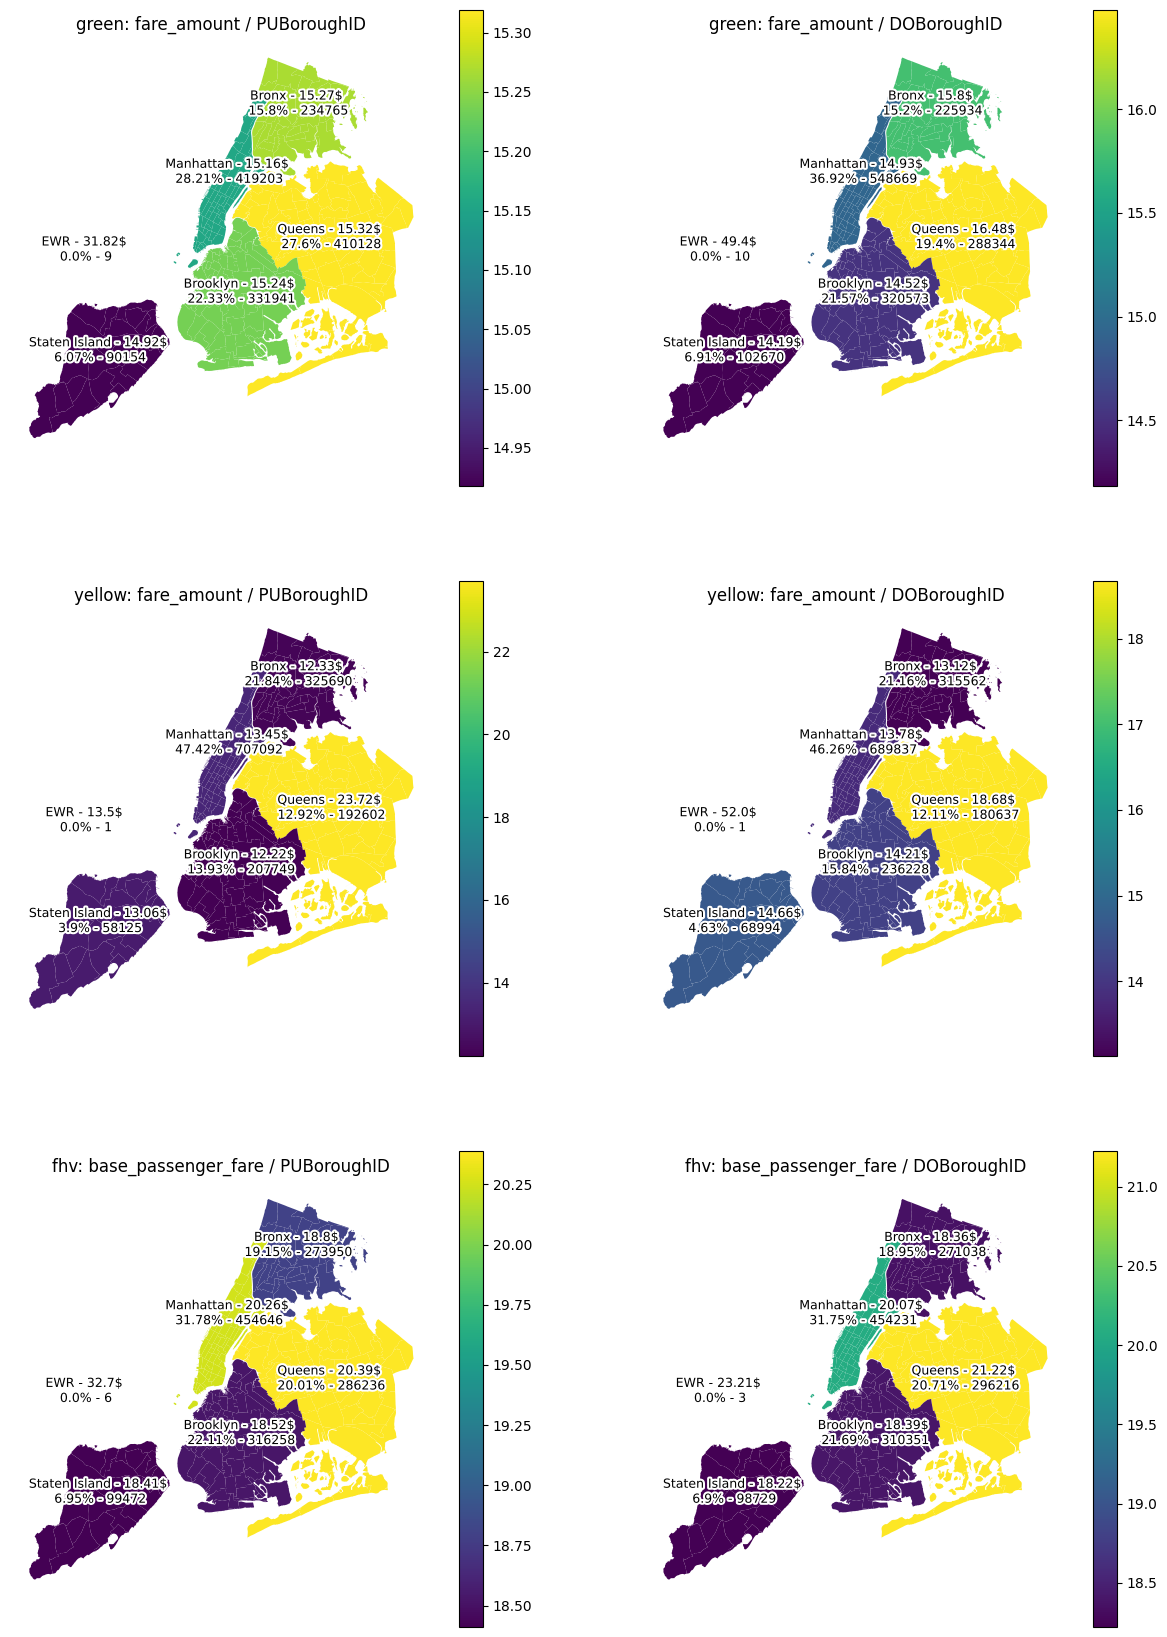

In [113]:
taxi_dict_values = {
    "green": "fare_amount", 
    "yellow": "fare_amount", 
    "fhv": "base_passenger_fare"
}

feature_subplots(
    taxi_dict_values=taxi_dict_values,
    csv_dict=csv_dict,
    zones_dict=zones_dict,
    samples_treshold=20,
    unit="$"
)

korelacje z macierzy:

```
tip_amount - PUL
tip_amount - DOL
trip_distance - PUL
trip_distance - DOL
RatecodeID - PUL
RatecodeID - DOL
fare_amount - PUL
fare_amount - DOL
tolls_amount - PUL
tolls_amount - DOL
total_amount - PUL
total_amount - DOL
congestion_surcharge - PUL
congestion_surcharge - DOL
airport_fee - PUL
airport_fee - DOL
```

In [93]:
csv_dict["fhv"]["valid"].columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag', 'retail_price',
       'temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'snowfall (cm)', 'snow_depth (m)', 'surface_pressure (hPa)',
       'cloud_cover (%)', 'wind_speed_10m (km/h)', 'is_day ()', 'PUBoroughID',
       'DOBoroughID'],
      dtype='object')

In [94]:
csv_dict["yellow"]["valid"].columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'retail_price',
       'temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'snowfall (cm)', 'snow_depth (m)', 'surface_pressure (hPa)',
       'cloud_cover (%)', 'wind_speed_10m (km/h)', 'is_day ()', 'PUBoroughID',
       'DOBoroughID'],
      dtype='object')